In [84]:
from params import *
from prepare_data import *
from model import *
from eval import *
from ast_models import *
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score, accuracy_score
import pandas as pd
import seaborn as sns
from to_json import *
from MixStyle import *
import time

Load the Constants

In [3]:
params = get_params()
DATASET_DIR = params['DATASET_DIR']
BATCH_SIZE = params['BATCH_SIZE']
AUDIO_DURATION = params['AUDIO_DURATION']
SAMPLING_RATE = params['SAMPLING_RATE']
MODEL_FILENAME = params['MODEL_FILENAME']
EPOCHS = params['EPOCHS']
N_MELS = params['N_MELS']
N_CLASSES = params['N_CLASSES']

Load the Data

In [4]:
# Load the data from json files
X_train, y_train, X_val, y_val, X_test, y_test = load_data("json_data/train2.json", 
                                                           "json_data/val2.json", 
                                                           "json_data/test2.json")

In [5]:
# Convert the arrays to 3D
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

Visualize the data

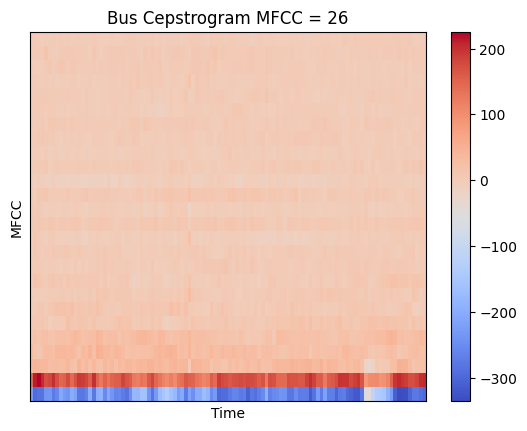

In [30]:
# Function to visualize audio data as a ceptrogram
file_path = 'CochlScene/CochlScene/Test/Bus/Bus_user0017_14896159_001.wav'
signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
mfcc = librosa.feature.mfcc(y=signal,
                             sr=sr,
                             n_fft=4096,
                             n_mfcc=26,
                             hop_length=4096)
librosa.display.specshow(mfcc, sr=sr, hop_length=4096)
plt.title("Bus Cepstrogram MFCC = 26")
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

Create Model

In [29]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

model = models.Sequential()

# 1st conv layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model.add(layers.BatchNormalization())

# 2nd conv layer 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model.add(layers.BatchNormalization())

# 3rd conv layer
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
model.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model.add(layers.BatchNormalization())

# Flatten output
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))

# Output layer
model.add(layers.Dense(13, activation='softmax'))

In [31]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 106, 24, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 53, 12, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 53, 12, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 10, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 26, 5, 32)         0         
 g2D)                                                            
                                                        

In [32]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_FILENAME, monitor="val_accuracy", save_best_only=True)
callbacks = [earlystopping_callback, checkpoint_callback]

history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks)

Epoch 1/100


1902/1902 [==============================] - 31s 15ms/step - loss: 1.4902 - accuracy: 0.4825 - val_loss: 1.2559 - val_accuracy: 0.5646
Epoch 2/100
   4/1902 [..............................] - ETA: 36s - loss: 1.2400 - accuracy: 0.5703 

C:\Users\reece\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1902/1902 [==============================] - 28s 15ms/step - loss: 1.1900 - accuracy: 0.5790 - val_loss: 1.6995 - val_accuracy: 0.4710
Epoch 3/100
1902/1902 [==============================] - 26s 14ms/step - loss: 1.0939 - accuracy: 0.6115 - val_loss: 1.1402 - val_accuracy: 0.6041
Epoch 4/100
1902/1902 [==============================] - 27s 14ms/step - loss: 1.0323 - accuracy: 0.6310 - val_loss: 1.3085 - val_accuracy: 0.5867
Epoch 5/100
1902/1902 [==============================] - 27s 14ms/step - loss: 0.9848 - accuracy: 0.6453 - val_loss: 1.1678 - val_accuracy: 0.6113
Epoch 6/100
1902/1902 [==============================] - 26s 14ms/step - loss: 0.9469 - accuracy: 0.6566 - val_loss: 1.1767 - val_accuracy: 0.5999
Epoch 7/100
1902/1902 [==============================] - 27s 14ms/step - loss: 0.9278 - accuracy: 0.6650 - val_loss: 1.1758 - val_accuracy: 0.6095
Epoch 8/100
1902/1902 [==============================] - 27s 14ms/step - loss: 0.9050 - accuracy: 0.6688 - val_loss: 1.2099 - val_

Evaluate

In [33]:
# Check the scores
y_pred = model.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)
print (classification_report(y_test, y_pred))

241/241 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       591
           1       0.42      0.59      0.49       593
           2       0.74      0.75      0.74       585
           3       0.41      0.42      0.41       592
           4       0.72      0.67      0.70       596
           5       0.76      0.80      0.78       600
           6       0.50      0.46      0.48       581
           7       0.48      0.49      0.48       581
           8       0.58      0.38      0.46       598
           9       0.84      0.76      0.80       600
          10       0.67      0.67      0.67       579
          11       0.53      0.69      0.60       595
          12       0.56      0.55      0.55       596

    accuracy                           0.60      7687
   macro avg       0.61      0.60      0.60      7687
weighted avg       0.61      0.60      0.60      7687



Train the same model, but without CrowdedIndoor

In [34]:
class_label_to_remove = 3

# Create a boolean mask where True corresponds to elements with the specified class label
mask = (y_train == class_label_to_remove)

# Invert the mask to keep the elements that do not have the specified class label
X_train2 = X_train[~mask]
y_train2 = y_train[~mask]

mask = (y_val == class_label_to_remove)
X_val2 = X_val[~mask]
y_val2 = y_val[~mask]

mask = (y_test == class_label_to_remove)
X_test2 = X_test[~mask]
y_test2 = y_test[~mask]

# Adjust all labels > 3 to 1 minus the current
condition = y_train2 > 3
y_train2[condition] = y_train2[condition] - 1

condition = y_val2 > 3
y_val2[condition] = y_val2[condition] - 1

condition = y_test2 > 3
y_test2[condition] = y_test2[condition] - 1

In [38]:
# Same model as the first one
input_shape2 = (X_train2.shape[1], X_train2.shape[2], X_train2.shape[3])

model2 = models.Sequential()

# 1st conv layer
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model2.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model2.add(layers.BatchNormalization())

# 2nd conv layer 
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model2.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model2.add(layers.BatchNormalization())

# 3rd conv layer
model2.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
model2.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model2.add(layers.BatchNormalization())

# Flatten output
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.3))

# Output layer
model2.add(layers.Dense(12, activation='softmax'))

In [39]:
opt2 = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt2, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 106, 24, 32)       320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 53, 12, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 53, 12, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 51, 10, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 5, 32)         0         
 ng2D)                                                           
                                                      

In [40]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_FILENAME, monitor="val_accuracy", save_best_only=True)
callbacks = [earlystopping_callback, checkpoint_callback]

history2 = model2.fit(
    X_train2, y_train2, 
    epochs=EPOCHS,
    validation_data=(X_val2, y_val2),
    callbacks=callbacks)

Epoch 1/100
1756/1756 [==============================] - 24s 13ms/step - loss: 1.3916 - accuracy: 0.5092 - val_loss: 1.3958 - val_accuracy: 0.5278
Epoch 2/100
   5/1756 [..............................] - ETA: 24s - loss: 1.2072 - accuracy: 0.5562

C:\Users\reece\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1756/1756 [==============================] - 24s 14ms/step - loss: 1.1059 - accuracy: 0.6115 - val_loss: 1.3047 - val_accuracy: 0.5727
Epoch 3/100
1756/1756 [==============================] - 22s 13ms/step - loss: 0.9990 - accuracy: 0.6485 - val_loss: 1.1585 - val_accuracy: 0.6196
Epoch 4/100
1756/1756 [==============================] - 25s 14ms/step - loss: 0.9398 - accuracy: 0.6672 - val_loss: 1.1644 - val_accuracy: 0.6216
Epoch 5/100
1756/1756 [==============================] - 31s 18ms/step - loss: 0.9004 - accuracy: 0.6809 - val_loss: 1.1635 - val_accuracy: 0.6391
Epoch 6/100
1756/1756 [==============================] - 24s 14ms/step - loss: 0.8570 - accuracy: 0.6947 - val_loss: 1.1629 - val_accuracy: 0.6289
Epoch 7/100
1756/1756 [==============================] - 23s 13ms/step - loss: 0.8257 - accuracy: 0.7064 - val_loss: 1.0852 - val_accuracy: 0.6521
Epoch 8/100
1756/1756 [==============================] - 22s 13ms/step - loss: 0.8001 - accuracy: 0.7131 - val_loss: 1.1744 - val_

In [41]:
y_pred2 = model2.predict(X_test2)
y_pred2 = tf.argmax(y_pred2, axis=1)
print (classification_report(y_test2, y_pred2))

222/222 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.61      0.75      0.67       591
           1       0.54      0.61      0.57       593
           2       0.76      0.77      0.76       585
           3       0.68      0.80      0.73       596
           4       0.83      0.75      0.78       600
           5       0.59      0.45      0.51       581
           6       0.46      0.42      0.44       581
           7       0.62      0.52      0.57       598
           8       0.78      0.86      0.82       600
           9       0.58      0.75      0.65       579
          10       0.68      0.58      0.62       595
          11       0.71      0.56      0.63       596

    accuracy                           0.65      7095
   macro avg       0.65      0.65      0.65      7095
weighted avg       0.65      0.65      0.65      7095



Train on a More complex model

In [53]:
# Same model as the first one
input_shape2 = (X_train2.shape[1], X_train2.shape[2], X_train2.shape[3])

model3 = models.Sequential()

# 1st conv layer
model3.add(layers.Permute((2,1,3), input_shape=input_shape2))
model3.add(layers.Conv2D(16, (7,7), padding="same"))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation("relu"))

# 2nd conv layer 
model3.add(layers.Conv2D(16, (7,7), padding="same"))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation("relu"))

model3.add(layers.MaxPool2D(pool_size=(5, 5)))
model3.add(layers.Dropout(0.3))

# 3rd conv layer 
model3.add(layers.Conv2D(32, (7,7), padding="same"))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation("relu"))

model3.add(layers.MaxPool2D(pool_size=(4, 20)))
model3.add(layers.Dropout(0.3))

# Flatten output
model3.add(layers.Flatten())
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dropout(0.3))

# Output layer
model3.add(layers.Dense(12, activation='softmax'))

In [54]:
opt3 = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=opt3, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_4 (Permute)         (None, 26, 108, 1)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 26, 108, 16)       800       
                                                                 
 batch_normalization_30 (Ba  (None, 26, 108, 16)       64        
 tchNormalization)                                               
                                                                 
 activation_18 (Activation)  (None, 26, 108, 16)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 26, 108, 16)       12560     
                                                                 
 batch_normalization_31 (Ba  (None, 26, 108, 16)       64        
 tchNormalization)                                   

In [56]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_FILENAME, monitor="val_accuracy", save_best_only=True)
callbacks = [earlystopping_callback, checkpoint_callback]

history3 = model3.fit(
    X_train2, y_train2, 
    epochs=EPOCHS,
    validation_data=(X_val2, y_val2),
    callbacks=callbacks)

Epoch 1/100
1756/1756 [==============================] - 41s 24ms/step - loss: 1.5887 - accuracy: 0.3934 - val_loss: 1.4544 - val_accuracy: 0.5005
Epoch 2/100
   4/1756 [..............................] - ETA: 40s - loss: 1.3778 - accuracy: 0.4922

C:\Users\reece\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1756/1756 [==============================] - 43s 25ms/step - loss: 1.3583 - accuracy: 0.5067 - val_loss: 1.3249 - val_accuracy: 0.5516
Epoch 3/100
1756/1756 [==============================] - 45s 26ms/step - loss: 1.2577 - accuracy: 0.5489 - val_loss: 1.2383 - val_accuracy: 0.5884
Epoch 4/100
1756/1756 [==============================] - 42s 24ms/step - loss: 1.1883 - accuracy: 0.5747 - val_loss: 1.2031 - val_accuracy: 0.6026
Epoch 5/100
1756/1756 [==============================] - 44s 25ms/step - loss: 1.1372 - accuracy: 0.5967 - val_loss: 1.1457 - val_accuracy: 0.6128
Epoch 6/100
1756/1756 [==============================] - 44s 25ms/step - loss: 1.1104 - accuracy: 0.6073 - val_loss: 1.1580 - val_accuracy: 0.6067
Epoch 7/100
1756/1756 [==============================] - 47s 27ms/step - loss: 1.0811 - accuracy: 0.6162 - val_loss: 1.1514 - val_accuracy: 0.5963
Epoch 8/100
1756/1756 [==============================] - 43s 24ms/step - loss: 1.0606 - accuracy: 0.6239 - val_loss: 1.1310 - val_

In [57]:
y_pred3 = model3.predict(X_test2)
y_pred3 = tf.argmax(y_pred3, axis=1)
print (classification_report(y_test2, y_pred3))

222/222 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

           0       0.62      0.61      0.61       591
           1       0.51      0.49      0.50       593
           2       0.75      0.75      0.75       585
           3       0.79      0.72      0.75       596
           4       0.89      0.66      0.76       600
           5       0.54      0.51      0.52       581
           6       0.43      0.50      0.47       581
           7       0.50      0.62      0.55       598
           8       0.78      0.85      0.81       600
           9       0.75      0.62      0.68       579
          10       0.58      0.59      0.59       595
          11       0.60      0.67      0.63       596

    accuracy                           0.63      7095
   macro avg       0.65      0.63      0.64      7095
weighted avg       0.65      0.63      0.64      7095



CNN with 4th Conv layer

In [72]:
# Same model as the first one
input_shape2 = (X_train2.shape[1], X_train2.shape[2], X_train2.shape[3])

model4 = models.Sequential()

# 1st conv layer
model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model4.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model4.add(layers.BatchNormalization())

# 2nd conv layer 
model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model4.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model4.add(layers.BatchNormalization())

# 3rd conv layer
model4.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
model4.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model4.add(layers.BatchNormalization())

# 4rd conv layer
model4.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=input_shape))
model4.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model4.add(layers.BatchNormalization())

# Flatten output
model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dropout(0.3))

# Output layer
model4.add(layers.Dense(12, activation='softmax'))

In [73]:
opt4 = tf.keras.optimizers.Adam(learning_rate=0.001)
model4.compile(optimizer=opt4, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model4.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 106, 24, 32)       320       
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 53, 12, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_68 (Ba  (None, 53, 12, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_69 (Conv2D)          (None, 51, 10, 32)        9248      
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 26, 5, 32)         0         
 ng2D)                                                           
                                                     

In [74]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_FILENAME, monitor="val_accuracy", save_best_only=True)
callbacks = [earlystopping_callback, checkpoint_callback]

history4 = model4.fit(
    X_train2, y_train2, 
    epochs=EPOCHS,
    validation_data=(X_val2, y_val2),
    callbacks=callbacks)

Epoch 1/100
1756/1756 [==============================] - 28s 15ms/step - loss: 1.3892 - accuracy: 0.5101 - val_loss: 1.4842 - val_accuracy: 0.5181
Epoch 2/100
   5/1756 [..............................] - ETA: 24s - loss: 1.0957 - accuracy: 0.6125

C:\Users\reece\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1756/1756 [==============================] - 23s 13ms/step - loss: 1.0846 - accuracy: 0.6161 - val_loss: 1.6242 - val_accuracy: 0.5205
Epoch 3/100
1756/1756 [==============================] - 23s 13ms/step - loss: 0.9945 - accuracy: 0.6461 - val_loss: 1.0876 - val_accuracy: 0.6401
Epoch 4/100
1756/1756 [==============================] - 23s 13ms/step - loss: 0.9465 - accuracy: 0.6646 - val_loss: 1.1235 - val_accuracy: 0.6175
Epoch 5/100
1756/1756 [==============================] - 23s 13ms/step - loss: 0.9062 - accuracy: 0.6802 - val_loss: 1.1645 - val_accuracy: 0.6129
Epoch 6/100
1756/1756 [==============================] - 23s 13ms/step - loss: 0.8795 - accuracy: 0.6870 - val_loss: 1.1621 - val_accuracy: 0.6152
Epoch 7/100
1756/1756 [==============================] - 23s 13ms/step - loss: 0.8508 - accuracy: 0.6990 - val_loss: 1.4804 - val_accuracy: 0.5656
Epoch 8/100
1756/1756 [==============================] - 24s 14ms/step - loss: 0.8330 - accuracy: 0.7041 - val_loss: 0.9966 - val_

In [75]:
y_pred4 = model4.predict(X_test2)
y_pred4 = tf.argmax(y_pred4, axis=1)
print (classification_report(y_test2, y_pred4))

222/222 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.81      0.56      0.66       591
           1       0.57      0.58      0.57       593
           2       0.75      0.82      0.78       585
           3       0.66      0.87      0.75       596
           4       0.78      0.82      0.80       600
           5       0.66      0.50      0.57       581
           6       0.52      0.44      0.48       581
           7       0.57      0.64      0.60       598
           8       0.83      0.77      0.80       600
           9       0.69      0.74      0.71       579
          10       0.59      0.75      0.66       595
          11       0.69      0.58      0.63       596

    accuracy                           0.67      7095
   macro avg       0.68      0.67      0.67      7095
weighted avg       0.68      0.67      0.67      7095



AttributeError: 'numpy.ndarray' object has no attribute 'savefig'

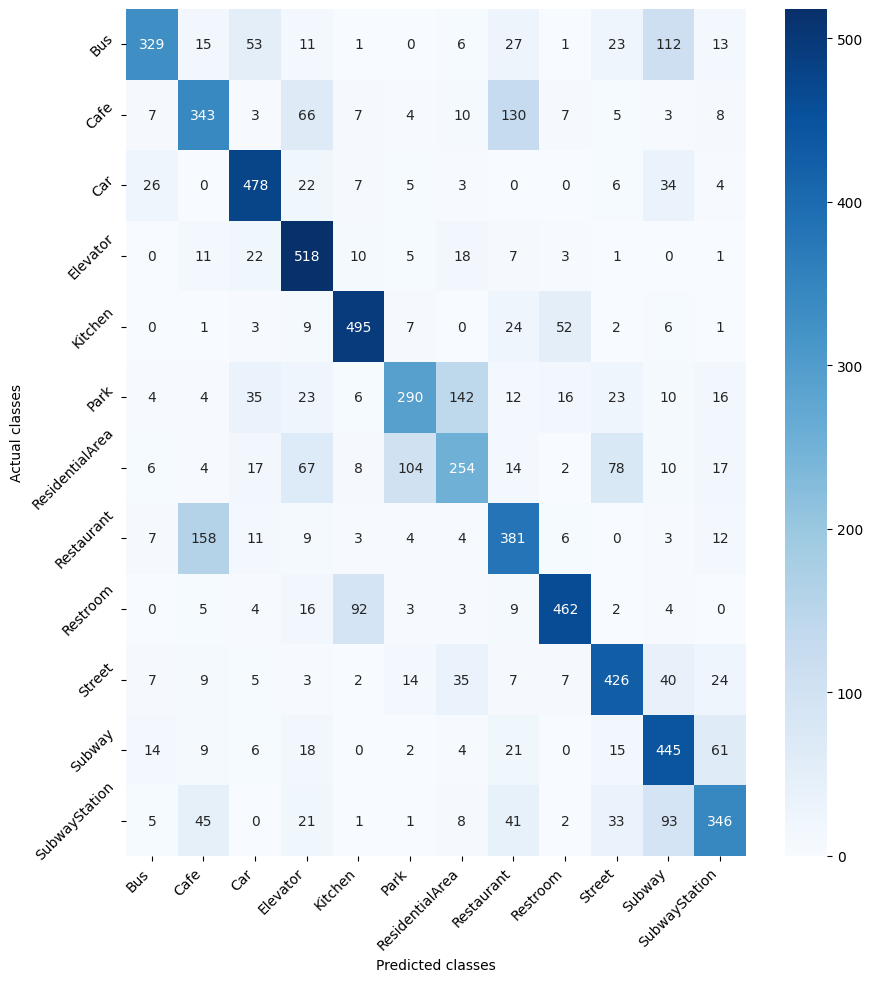

In [118]:
# Create the confusion matrix
labels = os.listdir(os.path.join(DATASET_DIR, "Train"))
labels.sort()
labels.remove('CrowdedIndoor')

cm = confusion_matrix(y_test2, y_pred4)
plt.figure(figsize=(10,11))
ax = sns.heatmap(cm, annot=True, fmt='d' ,cmap='Blues')

ax.set_xlabel('Predicted classes')
ax.set_ylabel('Actual classes');

ax.xaxis.set_ticklabels(labels, rotation=45, ha='right', minor=False)
ax.yaxis.set_ticklabels(labels, rotation=45, ha='right', minor=False)
cm.savefig('confusion_matrix.png')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot().figure_.savefig('confusion_matrix.png')

plt.show()

In [86]:
model5 = models.Sequential()

# 1st conv layer
model5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape2))
model5.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model5.add(MixStyle())

# 2nd conv layer 
model5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape2))
model5.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model5.add(MixStyle())

# 3rd conv layer
model5.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape2))
model5.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model5.add(layers.BatchNormalization())

# 4rd conv layer
model5.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=input_shape))
model5.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model5.add(layers.BatchNormalization())

# Flatten output
model5.add(layers.Flatten())
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dropout(0.3))

# Output layer
model5.add(layers.Dense(12, activation='softmax'))

In [87]:
opt5 = tf.keras.optimizers.Adam(learning_rate=0.001)
model5.compile(optimizer=opt5, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model5.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 106, 24, 32)       320       
                                                                 
 max_pooling2d_71 (MaxPooli  (None, 53, 12, 32)        0         
 ng2D)                                                           
                                                                 
 mix_style_1 (MixStyle)      (None, 53, 12, 32)        0         
                                                                 
 conv2d_79 (Conv2D)          (None, 51, 10, 32)        9248      
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 26, 5, 32)         0         
 ng2D)                                                           
                                                                 
 mix_style_2 (MixStyle)      (None, 26, 5, 32)       

In [88]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_FILENAME, monitor="val_accuracy", save_best_only=True)
callbacks = [earlystopping_callback, checkpoint_callback]

history5 = model5.fit(
    X_train2, y_train2, 
    epochs=EPOCHS,
    validation_data=(X_val2, y_val2),
    callbacks=callbacks)

Epoch 1/100
1756/1756 [==============================] - 25s 13ms/step - loss: 1.4143 - accuracy: 0.4997 - val_loss: 1.4992 - val_accuracy: 0.5049
Epoch 2/100
   4/1756 [..............................] - ETA: 32s - loss: 1.1314 - accuracy: 0.6016

C:\Users\reece\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1756/1756 [==============================] - 23s 13ms/step - loss: 1.1196 - accuracy: 0.6056 - val_loss: 1.2315 - val_accuracy: 0.5849
Epoch 3/100
1756/1756 [==============================] - 23s 13ms/step - loss: 1.0238 - accuracy: 0.6395 - val_loss: 1.1756 - val_accuracy: 0.6019
Epoch 4/100
1756/1756 [==============================] - 22s 13ms/step - loss: 0.9698 - accuracy: 0.6563 - val_loss: 1.3555 - val_accuracy: 0.5693
Epoch 5/100
1756/1756 [==============================] - 22s 13ms/step - loss: 0.9266 - accuracy: 0.6722 - val_loss: 1.1398 - val_accuracy: 0.6309
Epoch 6/100
1756/1756 [==============================] - 24s 14ms/step - loss: 0.9034 - accuracy: 0.6807 - val_loss: 1.1107 - val_accuracy: 0.6169
Epoch 7/100
1756/1756 [==============================] - 21s 12ms/step - loss: 0.8752 - accuracy: 0.6908 - val_loss: 1.2592 - val_accuracy: 0.5743
Epoch 8/100
1756/1756 [==============================] - 24s 14ms/step - loss: 0.8586 - accuracy: 0.6989 - val_loss: 1.0534 - val_

In [112]:
y_pred5 = model5.predict(X_test2)
y_pred5 = tf.argmax(y_pred5, axis=1)
print (classification_report(y_test2, y_pred5))

222/222 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.71      0.64      0.67       591
           1       0.56      0.64      0.60       593
           2       0.76      0.77      0.76       585
           3       0.69      0.85      0.76       596
           4       0.72      0.84      0.77       600
           5       0.61      0.49      0.55       581
           6       0.52      0.40      0.45       581
           7       0.74      0.42      0.54       598
           8       0.89      0.70      0.78       600
           9       0.67      0.68      0.68       579
          10       0.57      0.74      0.65       595
          11       0.57      0.73      0.64       596

    accuracy                           0.66      7095
   macro avg       0.67      0.66      0.65      7095
weighted avg       0.67      0.66      0.65      7095



One More Convolutional Layer

In [109]:
model6 = models.Sequential()

# 1st conv layer
model6.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape2))
model6.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model6.add(MixStyle())

# 2nd conv layer 
model6.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape2))
model6.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
model6.add(layers.BatchNormalization())

# 3rd conv layer
model6.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape2))
model6.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model6.add(layers.BatchNormalization())

# 4th conv layer
model6.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=input_shape))
model6.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model6.add(layers.BatchNormalization())

# 5th conv layer
model6.add(layers.Conv2D(8, (1, 1), activation='relu', input_shape=input_shape))
model6.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model6.add(layers.BatchNormalization())

# Flatten output
model6.add(layers.Flatten())
model6.add(layers.Dense(64, activation='relu'))
model6.add(layers.Dropout(0.3))

# Output layer
model6.add(layers.Dense(12, activation='softmax'))

In [110]:
opt6 = tf.keras.optimizers.Adam(learning_rate=0.001)
model6.compile(optimizer=opt6, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model6.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_122 (Conv2D)         (None, 106, 24, 32)       320       
                                                                 
 max_pooling2d_113 (MaxPool  (None, 53, 12, 32)        0         
 ing2D)                                                          
                                                                 
 mix_style_13 (MixStyle)     (None, 53, 12, 32)        0         
                                                                 
 conv2d_123 (Conv2D)         (None, 51, 10, 32)        9248      
                                                                 
 max_pooling2d_114 (MaxPool  (None, 26, 5, 32)         0         
 ing2D)                                                          
                                                                 
 batch_normalization_104 (B  (None, 26, 5, 32)       

In [111]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_FILENAME, monitor="val_accuracy", save_best_only=True)
callbacks = [earlystopping_callback, checkpoint_callback]

history6 = model6.fit(
    X_train2, y_train2, 
    epochs=EPOCHS,
    validation_data=(X_val2, y_val2),
    callbacks=callbacks)

Epoch 1/100
1756/1756 [==============================] - 24s 13ms/step - loss: 1.5179 - accuracy: 0.4529 - val_loss: 1.3089 - val_accuracy: 0.5477
Epoch 2/100
1756/1756 [==============================] - 22s 13ms/step - loss: 1.1736 - accuracy: 0.5886 - val_loss: 1.2365 - val_accuracy: 0.5746
Epoch 3/100
1756/1756 [==============================] - 22s 13ms/step - loss: 1.0738 - accuracy: 0.6227 - val_loss: 1.3840 - val_accuracy: 0.5478
Epoch 4/100
1756/1756 [==============================] - 22s 13ms/step - loss: 1.0087 - accuracy: 0.6458 - val_loss: 1.2052 - val_accuracy: 0.5879
Epoch 5/100
1756/1756 [==============================] - 22s 13ms/step - loss: 0.9719 - accuracy: 0.6621 - val_loss: 1.1013 - val_accuracy: 0.6212
Epoch 6/100
1756/1756 [==============================] - 22s 12ms/step - loss: 0.9379 - accuracy: 0.6721 - val_loss: 1.2113 - val_accuracy: 0.6015
Epoch 7/100
1756/1756 [==============================] - 22s 13ms/step - loss: 0.9115 - accuracy: 0.6824 - val_loss: 1

In [113]:
y_pred6 = model6.predict(X_test2)
y_pred6 = tf.argmax(y_pred6, axis=1)
print (classification_report(y_test2, y_pred6))

222/222 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       591
           1       0.48      0.75      0.58       593
           2       0.82      0.70      0.76       585
           3       0.65      0.82      0.73       596
           4       0.81      0.74      0.77       600
           5       0.60      0.45      0.52       581
           6       0.50      0.38      0.43       581
           7       0.59      0.45      0.51       598
           8       0.81      0.80      0.80       600
           9       0.64      0.76      0.70       579
          10       0.73      0.44      0.55       595
          11       0.55      0.78      0.64       596

    accuracy                           0.64      7095
   macro avg       0.66      0.64      0.64      7095
weighted avg       0.66      0.64      0.64      7095

